<a href="https://colab.research.google.com/github/psagar2/recipes/blob/main/split_divided.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction:
As per the World Health Organisation, each year approximately 1.3 million people lose their lives because of road accidents.[2] Along with drunk driving and unconsciousness, the major reason that seems to be contributing is distracted driving.
Distracted driver detection is a major contributor towards road accidents these days and accounting as public health threat these days.[1] For solving this problem, a video extracted images of distracted drivers’ dataset is used which is easily accessible on Kaggle. A model for real-time detection for distracted drivers and notifying them is required. Moreover, if this is combined with automated driving which is currently pursued by TESLA, will make this world a safer place to drive, and the number of accidents will reduce. It is quite well accepted that computer vision majorly gives the optimum results for image classification.  Hence for this distracted driver detection, CNN was applied.


# Literature Review:
In previous years Distracted driver detection has been a topic that has gathered the attention of many scientists. The work started in the early 90s when the mobile phone started to come into the scenario. Since then, usage of mobile while driving is one of the major contributors to the causes of distracted drivers [1]. With the advancement of technology, this started to increase as the users are increasing and dependence on smartphones is increasing day by day.¬¬ Many researchers have worked on this by making their datasets and applying models to them. Deep neural networks and convolution neural networks (CNN) have been used in the majority of the works till now. Some recent works include the model of ensemble learning for the prediction using video feed this was achieved by using CNN and combining it with Long Short-Term Memory which is part of RNN. This used sensor data along with an image to achieve ensemble learning [2]. 

Aggregation of CNN and Histogram of Gradients (HOG) has also been used for classification as this uses CNN for image processing and HOG is used for detection of human beings as it collects small gradients, processes their connections, and then normalize to use them for prediction of the regions [3]. Most of these research’s use pre-trained models for processing the images and using them for predictions mostly used are VGG 16, AlexNet, ResNet-50, and Inception V3. These models are used to provide pre-trained weights and their outputs are then flattened to add to certain layers than at the end mapped to categories for output. The number of intermediate layers depends on the researcher. The pretrained model is then combined with Human activity recognition models to detect the features of the driver using K-means Clustering [4]. As the data of sensors and the video, the dataset is not publicly available, and the computational resources are restricted in this project usage of the image is done that too with the pixel size of 160X160. If better computational resources are present, it is recommended to use 256X256 size images.



Installing json file and unzipping the data

In [ ]:
! pip install -q kaggle
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c state-farm-distracted-driver-detection

     |████████████████████████████████| 58 kB 5.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=1325302e0e07467dc81dc5fc2607661401e2b4a84d09ac3ea68faf5362188e8e
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
100% 3.99G/4.00G [00:33<00:00, 171MB/s]
100% 4.00G/4.00G [00:33<00:00, 130MB/s]


In [ ]:
! mkdir driverData
! unzip driverData.zip -d driverData

Streaming output truncated to the last 5000 lines.
  inflating: driverData/imgs/train/c7/img_56636.jpg  
  inflating: driverData/imgs/train/c7/img_56661.jpg  
  inflating: driverData/imgs/train/c7/img_56699.jpg  
  inflating: driverData/imgs/train/c7/img_56717.jpg  
  inflating: driverData/imgs/train/c7/img_56724.jpg  
  inflating: driverData/imgs/train/c7/img_56768.jpg  
  inflating: driverData/imgs/train/c7/img_56779.jpg  
  inflating: driverData/imgs/train/c7/img_56849.jpg  
  inflating: driverData/imgs/train/c7/img_56899.jpg  
  inflating: driverData/imgs/train/c7/img_56938.jpg  
  inflating: driverData/imgs/train/c7/img_5706.jpg  
  inflating: driverData/imgs/train/c7/img_57076.jpg  
  inflating: driverData/imgs/train/c7/img_57122.jpg  
  inflating: driverData/imgs/train/c7/img_57137.jpg  
  inflating: driverData/imgs/train/c7/img_5715.jpg  
  inflating: driverData/imgs/train/c7/img_57278.jpg  
  inflating: driverData/imgs/train/c7/img_57321.jpg  
  inflating: driverData/imgs/trai

Loading libraries

In [ ]:
pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=4e9eb7cbae91349f60fd582aa74fdb99e81b6f121c7d8303872fab04d7e3b92c
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
#loading the libraries
#for the usage of array:
import numpy as np 
#for impementing dataset and operations:
import pandasql as ps
import pandas as pd
#for traversing in the dataset:
import os
#to convert data in pickle files for reproducibility:
import pickle
#for applying computer vision on images:
import cv2
#to use image pre processing:
from keras.preprocessing import image
#to apply models
import tensorflow as tf
#to plot the charts
import matplotlib.pyplot as plt
#for applying machine models and layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

# Data pre-processing:
Dataset consists of 22426 images divided into 10 categories namely:
1.	Safe driving 
2.	Talking on the phone right
3.	Talking on the phone left
4.	Looking back 
5.	Talking to the passenger 
6.	Drinking 
7.	Texting right
8.	Texting left
9.	Hair and makeup 
10.	Operating the radio


The major challenge with this dataset is that it has quite similar images that confuse the model to easily determine the difference. Therefore, image augmentation is quite necessary for this dataset. 
Image augmentation types:
1. Horizontal flip: flips random images horizontally from the dataset.
2. Vertical flip: flips random images vertically from the dataset
3. Rotation range: randomly rotates images inside the dataset so our model can be robust.
4. Validation split: 0.3 that is 30% data split.
5. Fill mode=’nearest’:
6. Zoom range: randomly zooming images by 20%





In this project, these augmentations have been tried at different stages with different values and the values mentioned above are giving the best results. These augmentations have been applied inside through computer vision library CV2 and image data generator class, varying with the way data was considered.
There were 3 approaches considered on the dataset, those are providing the data through google drive and doing a train test split through a Keras function, taking the data from the drive and partitioning it based on people out of the 26 being considered for the study and the last one is partitioning through image data generator class. First, the Train test split was done by taking 30% as validation data and 70% as training data. Second, the Train test split based on people: as 26 participants have accounted for 22424 images, we randomly chose 6 people and added them to the test set so that training data and test data could be different.

Input shapes: (32,32,3), (64,64,3), (128,128,3) and (128,128,1). Images were imported on different pixel sizes and accuracy was drastically dropping in lower pixel sizes.  At 128 X 128 RGB to Gray was also considered to see if that enables models to get better accuracy with a lower number of hyperparameters and, hence, saves time and speed of computation.

Resizing of image: all the images are converted to NumPy array and then resized by 1/255 as the images have to be normalized to apply the image analysis. We can decide the batch size so that we can define how many photos are present in each batch. That is required as batch normalization needs to be applied which we will be discussed later in the report.


In [ ]:
# Image augmentation and Train test split
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.3,
                                   rotation_range=180,
                                   #shear_range=0.2,
                                   zoom_range=0.5,
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                   fill_mode='nearest',
                                   #featurewise_center=True,
                                   ) # set validation split

train_generator = train_datagen.flow_from_directory(
    '/content/driverData/imgs/train/',
    target_size=(160, 160),
    batch_size=128,
    ) # set as training data

validation_generator = train_datagen.flow_from_directory(
    '/content/driverData/imgs/train/',  # same directory as training data
    target_size=(160, 160),
    batch_size=128,
    subset='validation') # set as validation data

Found 22424 images belonging to 10 classes.
Found 6722 images belonging to 10 classes.


## Exploratory data analysis:
There are certain questions that how the data is distributed and how is it justifiable to consider the data? 
So, to answer these questions the distribution of data was considered, how many photos of each person are present is taken into account and the uniformity with categories is checked.
How many photos of each category are present? 


In [ ]:
# reading the csv
df1=pd.read_csv('/content/driverData/driver_imgs_list.csv')

In [ ]:
# finding the number of images using SQL
df2=ps.sqldf('select classname, count(img) as Number_of_images from df1 group by classname')

Text(0, 0.5, 'No. of Images')

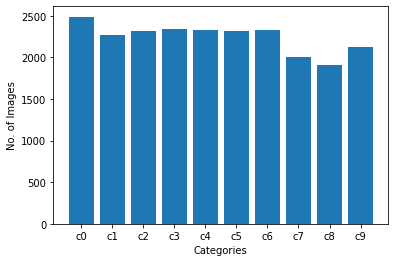

In [ ]:
# making a bar plot f the data
plt.bar(df2.classname, df2.Number_of_images)
plt.xlabel("Categories")
plt.ylabel("No. of Images")

As the data suggests there is an almost equal number of images in each category. That suggests the model can be easily trained on these images as no particular category would dominate others.

How many pictures of each driver are present? 


In [ ]:
df3=ps.sqldf('select subject, count(img) as Number_of_images from df1 group by subject')
df3

,subject,Number_of_images
0,p002,725
1,p012,823
2,p014,876
3,p015,875
4,p016,1078
5,p021,1237
6,p022,1233
7,p024,1226
8,p026,1196
9,p035,848


This was needed to be checked as if one particular driver dominates the whole dataset because if that isthe case there are chances that the model would start classifying based on that driver’s features.

## Input and Output Layers components:
1.	Conv 2D: convolution layer of 2 dimensions is run over an image using a spatial matrix which uses filters which are values of the 2 dimensions, strides these are the number of pixels to skip by the filter, kernel size is the filter size for the image.
2.	Max pooling:  CNN works by extracting the features from the image. For example, in the texting right category, we have a mobile phone in the right hand as one of the features. Now as the spatial matrix traverse over the image to learn it might learn some features as it is. So the model will not predict if it is rotated or present in a different scenario. Down sampling that is reducing the resolution is required. Hence max pooling is one of the types of down sampling which considers the matrix of a certain size chooses the maximum value out of those pixels and replaces it instead.
3.	Dense: dense layer is a fully connected layer to its preceding layer and it takes all the neurons information from the previous layer and adds bias to the value. Then the value is passed to the activation function which determines the value of this node.
4.	Dropout: dropout layer works with setting the neurons input values with 0. It doesn’t let the model overfit and replaces the values with 0 and change the other values with 1/(1-rate) such that the sum of all inputs is unchanged.
5.	Batch normalization: batch normalization works to maintain mean output as 0 and works to maintain standard deviation of output at 1. This is a transformation that works in 2 different ways when applied to training or testing samples for training it needs to be applied during fit function and for testing it is applied at evaluation.
6.	Filter size: the filter size works to extract the features as the filters move over an image it returns the value by multiplying an n-dimensional matrix which only has the values over the diagonal and those values are 1. It extracts those features and returns the value. The filter size that is the value of n depends on the training data and type of features.
7.	Input shape: the input shape depends on the images’ pixel size, the features needed for classification, and the available computational resources. 
8.	Activation functions:
    1.	Tanh: tanh function is straight from the trigonometry returns the value of (exp(x)-exp(-x)) /(exp(x)+exp(-x))
    8.	Sigmoid: Sigmoid function returns the values between 0 and 1 it uses a function that considers the equation of 1/1+exp(-x). So, it returns the value nearby zero if the value of x is small and near to 1 if the value of X is big.
    8.	ReLu: Rectified Linear unit is a function that returns the value of the maximum of 2 values in which the first is 0 and the second is x (the input vector). This returns all the positive values.
    8.	Swish: this is a fairly new activation function; it has not been included in the official Keras documentation till now. It is an extension of the sigmoid function that is it returns the value of x*sigmoid(x).
    8.	SoftMax: The SoftMax function works on the idea of probability distribution and returns the output vector whose values are in the range of 0 and 1. Also, the sum of these output vectors is 1. This is majorly used in the last layer of the model for classification purposes.
9.	Optimizers used:
    1.	 SGD: stochastic gradient descent is an originally robust model that shapes most optimizers today. Sgd learning power in the model is bit less than and takes more than 40 epochs to learn to optimum value. Its learning rate is kept at 0.01. If kept at lower value model might be underfit.
    2.	 ADAM: Adam is the method that is based on the adaptive estimation of stochastic gradient descent. It is the most used optimizer. Its learning rate is 0.001. As Adam is very powerfull it tends to overfit on the model with validation accuracy being low. So The learning rate has been kept low.


# Methodology:
The model chosen here is sequential, the first convolution layer has 64 nodes and a 16X16 filter for adequate feature attraction. The activation function used for the first layer is swish. Max pooling filter of 2X2 used here for a down sampling. After this, a dropout layer is introduced with a 0.2 value that is 20 percent of the nodes are replaced with 0, and the rest are multiplied by 1/0.8. After that, nodes are increased to 128 so that the features can be further divided and processed again the same filter of 16X16 is passed to analyze and activation functions are kept the same. Here max-pooling of 4X4 is added with strides value as 2 which means this will skip 1 in between for down sampling. Again, a dropout of 20% is used. After this, the output is flattened and mapped with a hidden layer of 1024 units where activation function ReLu is used. Then the next hidden layer concise the size to converge the learning of the nodes and drive towards the conclusion hence has 256 nodes with a dropout of 0.2. The next layer has 128 nodes with activation function swish. Then dropout with 0.2 is introduced here which finally maps with the output layer which returns a predicted value which is one hot encoded and this is then deciphered to know the predicted category and check the accuracy.


CNN 5 Layer Model

In [ ]:
#CNN 5 Layer model
#initialising the model
model12=Sequential()
#first input layer
model12.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(128,128,3)))
model12.add(MaxPooling2D(pool_size=(2,2)))
model12.add(Dropout(0.2))
#second layer
model12.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model12.add(MaxPooling2D(pool_size=(2,2)))
model12.add(Dropout(0.2))
#to make a full connection flatten layer is used
model12.add(Flatten())
#third layer
model12.add(Dense(128,activation='relu'))
model12.add(Dropout(0.5))
#fourth layer
model12.add(Dense(64,activation='relu'))
#output layer
model12.add(Dense(10, activation='softmax'))
model12.summary()
#compiling the model on the basis of categorical crossentropy
model12.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
hist12=model12.fit(train_generator,epochs=50,validation_data=(validation_generator), verbose=1)
print("Model Training Complete...")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 128)      

CNN 6 Layer Model

In [ ]:
model6=Sequential()
#input layer
model6.add(Conv2D(64, (16,16), activation='swish', padding='same', input_shape=(160,160,3)))
model6.add(MaxPooling2D(pool_size=(2,2),strides=2))
model6.add(Dropout(0.2))
#second layer
model6.add(Conv2D(128, (16,16), activation='swish', padding='same'))
model6.add(MaxPooling2D(pool_size=(4,4),strides=2))
model6.add(Dropout(0.2))
#flatten layer for full connection
model6.add(Flatten())
#third layer
model6.add(Dense(1024,activation='relu'))
#Fourth layer
model6.add(Dense(256,activation='swish'))
model6.add(Dropout(0.2))
#fifth layer
model6.add(Dense(128,activation='swish'))
model6.add(Dropout(0.2))
# sixth/output layer
model6.add(Dense(10, activation='softmax'))

model6.summary()
#compiling on the basis of sgd optimizer on same loss function
model6.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

hist6=model6.fit(train_generator,epochs=70,validation_data=(validation_generator), batch_size=128, verbose=1)
print("Model Training Complete...")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 160, 160, 64)      49216     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 80, 80, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 80, 80, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 80, 80, 128)       2097280   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 39, 128)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 39, 39, 128)      

Epoch 1/20
176/176 [==============================] - 249s 1s/step - loss: 0.2991 - accuracy: 0.9027 - val_loss: 0.2113 - val_accuracy: 0.9350
Epoch 2/20
176/176 [==============================] - 247s 1s/step - loss: 0.3040 - accuracy: 0.8985 - val_loss: 0.2007 - val_accuracy: 0.9377
Epoch 3/20
176/176 [==============================] - 247s 1s/step - loss: 0.2929 - accuracy: 0.9040 - val_loss: 0.1960 - val_accuracy: 0.9369
Epoch 4/20
176/176 [==============================] - 247s 1s/step - loss: 0.2886 - accuracy: 0.9047 - val_loss: 0.1898 - val_accuracy: 0.9411
Epoch 5/20
176/176 [==============================] - 246s 1s/step - loss: 0.2889 - accuracy: 0.9066 - val_loss: 0.1927 - val_accuracy: 0.9399
Epoch 6/20
176/176 [==============================] - 247s 1s/step - loss: 0.2701 - accuracy: 0.9113 - val_loss: 0.1774 - val_accuracy: 0.9461
Epoch 7/20
176/176 [==============================] - 248s 1s/step - loss: 0.2670 - accuracy: 0.9135 - val_loss: 0.1790 - val_accuracy: 0.9463

### Testing the accuracy

In [ ]:
import numpy as np 
from skimage.transform import resize
import matplotlib.pyplot as plt



my_img = plt.imread("img1.jpg")

my_img_resized = resize(my_img,(160,160,3))

probabilities = model6.predict(np.array([my_img_resized,]))
number_to_class = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities[0,:])
print("Image 1:", number_to_class[index[9]], "-- Possibility:", probabilities[0,index[9]]*100, "%")


# image 2
my_img2 = plt.imread("img2.jpg")
my_img2_resized = resize(my_img2,(160,160,3))

probabilities2 = model6.predict(np.array([my_img2_resized,]))
number_to_class2 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities2[0,:])
print("Image 2:", number_to_class2[index[9]], "-- Possibility:", probabilities2[0,index[9]]*100, "%")



# image 3
my_img3 = plt.imread("img3.jpg")
my_img3_resized = resize(my_img3,(160,160,3))

probabilities3 = model6.predict(np.array([my_img3_resized,]))
number_to_class3 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities3[0,:])
print("Image 3:", number_to_class3[index[9]], "-- Possibility:", probabilities3[0,index[9]]*100, "%")



# image 4
my_img4 = plt.imread("img4.jpg")
my_img4_resized = resize(my_img4,(160,160,3))

probabilities4 = model6.predict(np.array([my_img4_resized,]))
number_to_class4 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities4[0,:])
print("Image 4:", number_to_class4[index[9]], "-- Possibility:", probabilities4[0,index[9]]*100, "%")


# image 5
my_img5 = plt.imread("img5.jpg")
my_img5_resized = resize(my_img5,(160,160,3))

probabilities5 = model6.predict(np.array([my_img5_resized,]))
number_to_class5 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities5[0,:])
print("Image 5:", number_to_class5[index[9]], "-- Possibility:", probabilities5[0,index[9]]*100, "%")


# image 6
my_img6 = plt.imread("img6.jpg")
my_img6_resized = resize(my_img6,(160,160,3))

probabilities6 = model6.predict(np.array([my_img6_resized,]))
number_to_class6 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities6[0,:])
print("Image 6:", number_to_class6[index[9]], "-- Possibility:", probabilities6[0,index[9]]*100, "%")


# image 7
my_img7 = plt.imread("img7.jpg")
my_img7_resized = resize(my_img7,(160,160,3))

probabilities7 = model6.predict(np.array([my_img7_resized,]))
number_to_class7 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities7[0,:])
print("Image 7:", number_to_class7[index[9]], "-- Possibility:", probabilities7[0,index[9]]*100, "%")


# image 8
my_img8 = plt.imread("img8.jpg")
my_img8_resized = resize(my_img8,(160,160,3))

probabilities8 = model6.predict(np.array([my_img8_resized,]))
number_to_class8 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities8[0,:])
print("Image 8:", number_to_class8[index[9]], "-- Possibility:", probabilities8[0,index[9]]*100, "%")

# image 9
my_img9 = plt.imread("img9.jpg")
my_img9_resized = resize(my_img9,(160,160,3))

probabilities9 = model6.predict(np.array([my_img9_resized,]))
number_to_class9 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities9[0,:])
print("Image 9:", number_to_class9[index[9]], "-- Possibility:", probabilities9[0,index[9]]*100, "%")

# image 10
my_img10 = plt.imread("img10.jpg")
my_img10_resized = resize(my_img10,(160,160,3))

probabilities10 = model6.predict(np.array([my_img10_resized,]))
number_to_class10 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities10[0,:])
print("Image 10:", number_to_class10[index[9]], "-- Possibility:", probabilities10[0,index[9]]*100, "%")

Image 1: Operating the radio -- Possibility: 99.99854564666748 %
Image 2: Talking on the phone - right -- Possibility: 78.96634936332703 %
Image 3: Talking on the phone - left -- Possibility: 99.79065656661987 %
Image 4: Talking on the phone - right -- Possibility: 90.80380201339722 %
Image 5: Texting - left -- Possibility: 98.76547455787659 %
Image 6: Texting - right -- Possibility: 99.99204874038696 %
Image 7: Texting - right -- Possibility: 86.02083921432495 %
Image 8: Texting - left -- Possibility: 98.12450408935547 %
Image 9: Operating the radio -- Possibility: 98.7622857093811 %
Image 10: Operating the radio -- Possibility: 99.48786497116089 %


In [ ]:
model10 = Sequential() 


# first layer of the neural network. 
model10.add(Conv2D(32,(8,8), activation = 'relu', padding = 'same', input_shape = (160,160,3)))
model10.add(MaxPooling2D(pool_size=(2,2)))
model10.add(Dropout(0.2))
#second layer
model10.add(Conv2D(128,(8,8), activation = 'relu', padding = 'same'))
model10.add(MaxPooling2D(pool_size=(2,2)))
model10.add(Flatten())
#3rd layer
model10.add(Dense(128, activation = 'relu'))
model10.add(Dropout(0.2))
#4th layer
model10.add(Dense(64, activation = 'relu'))
model10.add(Dropout(0.2))
#5th layer
model10.add(Dense(10, activation = 'softmax'))


model10.summary()
model10.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
hist10=model10.fit(train_generator,epochs=100,validation_data=validation_generator, verbose=1)
print("Model Training Complete...")

In [ ]:
ImplementingVGG16=tf.keras.applications.VGG16(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')
mod1=ImplementingVGG16.output
mod1=tf.keras.layers.Flatten()(mod1)
mod1=tf.keras.layers.Dense(units=256, activation=tf.nn.relu)(mod1)
mod1=tf.keras.layers.Dense(units=256, activation=tf.nn.relu)(mod1)
output1=tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)(mod1)
model1= tf.keras.models.Model(inputs=ImplementingVGG16.inputs,outputs=output1)

model1.compile(optimizer=tf.keras.optimizers.Adam(0.00000005),
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits= False),
             metrics=['accuracy'])
model1.summary()
hist1=model1.fit(train_generator,epochs=50,validation_data=(validation_generator), verbose=1)
print("Model Training Complete...")

In [ ]:
ImplementingResNet=tf.keras.applications.resnet.ResNet50(include_top= False, 
                                                         weights='imagenet',
                                                         input_shape= (input_shape_value))
ImplementingResNet.summary()
mod=ImplementingResNet.output
mod=tf.keras.layers.Flatten()(mod)
mod=tf.keras.layers.Dense(units=32, activation=tf.nn.relu)(mod)
mod=tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(mod)
output=tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)(mod)
model8= tf.keras.models.Model(inputs=ImplementingResNet.inputs,outputs=output)

model8.compile(optimizer=tf.keras.optimizers.Adam(0.0000005),
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits= False),
             metrics=['accuracy'])
model8.summary()
hist8=model8.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test), verbose=1)
print("Model Training Complete...")

In [ ]:
ImplementingInception=tf.keras.applications.MobileNetV2(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')
mod2=ImplementingInception.output
mod2=tf.keras.layers.Flatten()(mod2)
mod2=tf.keras.layers.Dense(units=32, activation=tf.nn.relu)(mod2)
output2=tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)(mod2)
model2= tf.keras.models.Model(inputs=ImplementingInception.inputs,outputs=output2)

model2.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits= False),
             metrics=['accuracy'])
model2.summary()
history=model2.fit(train_generator,epochs=30,verbose=1)
print("Model Training Complete...")
(loss, accuracy) =model2.evaluate(validation_generator,batch_size=128, verbose=1)
print("accuracy: {:.2f}%".format(accuracy*100))
model

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)           

In [ ]:
model2.save('incep.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
import numpy as np 
from skimage.transform import resize
import matplotlib.pyplot as plt



my_img = plt.imread("img1.jpg")

my_img_resized = resize(my_img,(160,160,3))

probabilities = model6.predict(np.array([my_img_resized,]))
number_to_class = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities[0,:])
print("Image 1:", number_to_class[index[9]], "-- Possibility:", probabilities[0,index[9]]*100, "%")


# image 2
my_img2 = plt.imread("img2.jpg")
my_img2_resized = resize(my_img2,(160,160,3))

probabilities2 = model6.predict(np.array([my_img2_resized,]))
number_to_class2 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities2[0,:])
print("Image 2:", number_to_class2[index[9]], "-- Possibility:", probabilities2[0,index[9]]*100, "%")



# image 3
my_img3 = plt.imread("img3.jpg")
my_img3_resized = resize(my_img3,(160,160,3))

probabilities3 = model6.predict(np.array([my_img3_resized,]))
number_to_class3 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities3[0,:])
print("Image 3:", number_to_class3[index[9]], "-- Possibility:", probabilities3[0,index[9]]*100, "%")



# image 4
my_img4 = plt.imread("img4.jpg")
my_img4_resized = resize(my_img4,(160,160,3))

probabilities4 = model6.predict(np.array([my_img4_resized,]))
number_to_class4 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities4[0,:])
print("Image 4:", number_to_class4[index[9]], "-- Possibility:", probabilities4[0,index[9]]*100, "%")


# image 5
my_img5 = plt.imread("img5.jpg")
my_img5_resized = resize(my_img5,(160,160,3))

probabilities5 = model6.predict(np.array([my_img5_resized,]))
number_to_class5 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities5[0,:])
print("Image 5:", number_to_class5[index[9]], "-- Possibility:", probabilities5[0,index[9]]*100, "%")


# image 6
my_img6 = plt.imread("img6.jpg")
my_img6_resized = resize(my_img6,(160,160,3))

probabilities6 = model6.predict(np.array([my_img6_resized,]))
number_to_class6 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities6[0,:])
print("Image 6:", number_to_class6[index[9]], "-- Possibility:", probabilities6[0,index[9]]*100, "%")


# image 7
my_img7 = plt.imread("img7.jpg")
my_img7_resized = resize(my_img7,(160,160,3))

probabilities7 = model6.predict(np.array([my_img7_resized,]))
number_to_class7 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities7[0,:])
print("Image 7:", number_to_class7[index[9]], "-- Possibility:", probabilities7[0,index[9]]*100, "%")


# image 8
my_img8 = plt.imread("img8.jpg")
my_img8_resized = resize(my_img8,(160,160,3))

probabilities8 = model6.predict(np.array([my_img8_resized,]))
number_to_class8 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities8[0,:])
print("Image 8:", number_to_class8[index[9]], "-- Possibility:", probabilities8[0,index[9]]*100, "%")

# image 9
my_img9 = plt.imread("img9.jpg")
my_img9_resized = resize(my_img9,(160,160,3))

probabilities9 = model6.predict(np.array([my_img9_resized,]))
number_to_class9 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities9[0,:])
print("Image 9:", number_to_class9[index[9]], "-- Possibility:", probabilities9[0,index[9]]*100, "%")

# image 10
my_img10 = plt.imread("img10.jpg")
my_img10_resized = resize(my_img10,(160,160,3))

probabilities10 = model6.predict(np.array([my_img10_resized,]))
number_to_class10 = ['Safe driving','Texting - right', 'Talking on the phone - right', 'Texting - left', 'Talking on the phone - left', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger']

index = np.argsort(probabilities10[0,:])
print("Image 10:", number_to_class10[index[9]], "-- Possibility:", probabilities10[0,index[9]]*100, "%")

#Results:


 


>  Table 1. accuracy

Model name  | Test Accuracy|Number of Epochs| Activation function| optimizers| Filters
-------------------|------------------|-----------|-----------|-----|-----
Resnet 50| 97.61| 10|ReLu|Adam|NA
Vgg16|97.44| 10|ReLu|Adam|NA
Inception v3| 94.32| 30|ReLu|Adam|NA
CNN 6 layer| 98.01| 50|Swish|Sgd|16X16
CNN 5 Layer| 98| 100|Swish|Sgd|8X8
CNN 5 Layer| 73| 50|ReLu|Adam|3X3




As it is all the models have been tried with a lot of different hyperparameters that are different numbers of nodes in each layer, each model has been trained for different filter sizes, all the optimizers and activation functions have been applied and the best giving results have been presented here. This report suggests a CNN model of 6 layers as it gives 98 % accuracy and when given 10 random images it predicts 9 on 10 correctly with more than 95% possibility for each category. As compared to other models this model returns the best predictions on random images.



The following images are provided in this sequence to all the models for prediction. The prediction of all 10 pictures from CNN-6 (the recommended model) has been provided below for verification purposes.  For all other models, code has been provided along with the data for comparison and verification. Due to the limited amount of time and resources, these were the best results that were acquired. All the models have been trained on Google colab pro and hence only an ipynb file can be provided. 

## Future Scope
For better results, there can be more work done on pre-trained models as they drastically reduce the number of hyperparameters and train quite fast. As in this project, Google Colab provides GPU to work with it was easier to train with 201 million hyperparameters too. If fewer resources are available to anyone trying to replicate this model, it is recommended to use 64X64 pixel images that can provide the accuracy but feature extraction isn’t that good. So, the results might be a bit faulty. If the resources are adequate it is recommended to use 256X256 pixel images. It can be combined to an alert system to avoid accidents and make driver concentrate towards driving or launch auto pilot in case any mishap chance is present.

## Reflection
This project gave me a chance to learn about patience and how it is important to work with version control. I got to learn that different perspective in slightest of things can make a huge difference. As this markdown only contains final version of models there are 15 versions that have been saved and discarded. Also introspection of each version gave me a chance to achieve the model accuracy. This whole project took 28 days in whole to be completed.


## References:
1.	H. T. S. Administration, "Distracted driving ", ed, 2017, pp. https://www.nhtsa.gov/risky-driving/distracted-driving.
2.	F. Omerustaoglu, C. O. Sakar, and G. Kar, "Distracted driver detection by combining in-vehicle and image data using deep learning," Applied Soft Computing, vol. 96, 2020, doi: 10.1016/j.asoc.2020.106657.
3.	F. M. Md Rifat Arefin, Oksam Chae, Jaemyun Kim∗, "Aggregating_CNN_and_HOG_features_for_Real-Time_Distracted_Driver_Detection.pdf."
4.	S. J. Jiao, L. Y. Liu, and Q. Liu, "A Hybrid Deep Learning Model for Recognizing Actions of Distracted Drivers," Sensors (Basel), vol. 21, no. 21, Nov 8 2021, doi: 10.3390/s21217424.



NOTE:
For implementation of other models whose execution isn't present you can run this file or I am providing other ipynb notebooks which contain their output.